In [44]:
import sys
sys.path.append("../")
import copy

import time
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', "svg")
import matplotlib.colors
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from OcelotMinimal.cpbd import elements

from TorchOcelot.Lattice import SIS18_Lattice, SIS18_Lattice_minimal
from TorchOcelot.Models import LinearModel


general settings

In [45]:
# torch.set_printoptions(precision=3, sci_mode=False)

dtype = torch.float32
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("running on {}".format(device))

dim = 6

running on cpu


create model

In [46]:
lattice = SIS18_Lattice(k1f=0.3217252108633675, k1d=-0.49177734861791)
model = LinearModel(lattice, dim, dtype)
model = model.to(device)
model.setTrainable("quadrupoles")

modelNoTraining = copy.deepcopy(model).requires_grad_(False)

create accelerator

In [47]:
# create model of perturbed accelerator
perturbedLattice = SIS18_Lattice()

# get index of first quad
for i in range(len(perturbedLattice.sequence)):
    if type(perturbedLattice.sequence[i]) is elements.Quadrupole:
        idxFirstQuad = i

perturbedLattice.sequence[idxFirstQuad].k1 *= 0.98
perturbedLattice.update_transfer_maps()

perturbedModel = LinearModel(perturbedLattice, dim, dtype)
perturbedModel = perturbedModel.to(device)
_ = perturbedModel.requires_grad_(False)

load bunch

In [48]:
bunch = np.loadtxt("../../../res/bunch_6d_n=1e5.txt.gz")
bunch = torch.as_tensor(bunch, dtype=dtype)[:20,:dim]
bunch = bunch - bunch.permute(1, 0).mean(dim=1)  # set bunch centroid to 0 for each dim
bunch = bunch.to(device)

visualize trajectories

In [49]:
def plotTrajectories(model, bunch, ax):
    with torch.no_grad():
        trackRes = model(bunch, outputPerElement=True).detach().numpy()
    
    for particle in trackRes:
        ax.plot(model.lattice.endPositions, particle[0])
    return

Text(0, 0.5, 'perturbed')

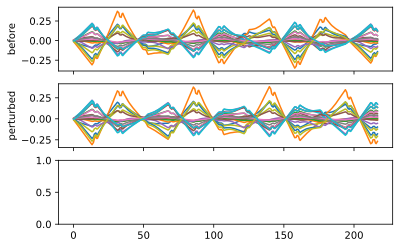

In [50]:
figTraj, axTraj = plt.subplots(3, 1, sharex=True)

plotTrajectories(modelNoTraining, bunch, axTraj[0])
plotTrajectories(perturbedModel, bunch, axTraj[1])

axTraj[0].set_ylabel("before")
axTraj[1].set_ylabel("perturbed")

create training data

In [51]:
outputPerElement = False
outputAtBPM = True

with torch.no_grad():
    bunchLabels = perturbedModel(bunch, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM)

bunch = bunch.to("cpu")
bunchLabels = bunchLabels.to("cpu")

trainSet = torch.utils.data.TensorDataset(bunch, bunchLabels)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=100,
                                          shuffle=True, num_workers=2)

optimization setup

In [52]:
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [53]:
print("initial loss: {}, initial regularization {}".format(criterion(model(bunch, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM), bunchLabels), model.symplecticRegularization()))

tunes = list()
t0 = time.time()
for epoch in range(2500):
    for i, data in enumerate(trainLoader):
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward, backward
        output = model(inputs, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM)
        loss = criterion(output, labels) +  model.symplecticRegularization()
        # loss = criterion(output, labels) + model.symplecticRegularization()
        # loss = criterion(output, labels)
        loss.backward()

        # do step in gradient descent
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-3)

        optimizer.step()

        # # report progress
        # if i % 100 == 99:
        #     print(loss.item())
        
        # observe tune
        tunes.append(model.getTunes())

    if epoch % 100 == 99:
        print("\r" + "epoch: {}".format(epoch + 1))

print("training completed within {:.2f}s".format(time.time() - t0))
print("final loss: {}, final regularization {}".format(criterion(model(bunch, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM), bunchLabels), model.symplecticRegularization()))

initial loss: 0.0008167185005731881, initial regularization 21.188020706176758
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900
epoch: 1000
epoch: 1100
epoch: 1200
epoch: 1300
epoch: 1400
epoch: 1500
epoch: 1600
epoch: 1700
epoch: 1800
epoch: 1900
epoch: 2000
epoch: 2100
epoch: 2200
epoch: 2300
epoch: 2400
epoch: 2500
training completed within 227.78s
final loss: 6.3161205616779625e-06, final regularization 21.29058837890625


show final trajectories

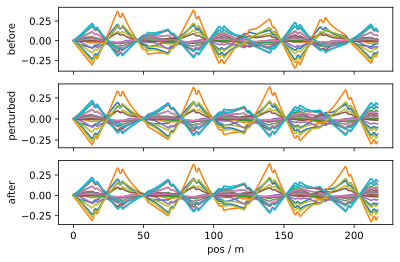

In [54]:
plotTrajectories(model, bunch, axTraj[2])

axTraj[2].set_ylabel("after")
axTraj[2].set_xlabel("pos / m")

display(figTraj)

compare tunes

In [55]:
print("before: {}".format(modelNoTraining.getTunes()))
print("perturbed: {}".format(perturbedModel.getTunes()))
print("after: {}".format(model.getTunes()))

before: [0.3834461369855988, 0.38063980198311753]
perturbed: [0.20941532647263114, 0.29346503513237393]
after: [0.2384640261489569, 0.34518880551553266]
